In [14]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.circuit.library import XGate
from qiskit.circuit.library.standard_gates.x import MCXGate
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot
from tensorflow.keras.metrics import categorical_crossentropy
from scipy.optimize import minimize

We will encode our images using the NEQR technique. NEQR stands for Novel Enhanced Quantum Representation. A description of this method along with an example encoding for 2x2 images. In our case, we will try to achieve results with the regular 28x28 size, and with a reduced size of 16x16.

In [15]:
#image encoding - NEQR

def conv_decimal_binary(num):
    '''Takes in a decimal number and returns the binary bit string'''
    return "{0:08b}".format(num)

def conv_binary_decimal(bitstring):
    '''Takes in a string of bits and returns the decimal number'''
    return int(s,2)

def encode_pixel_no(circuit, no):
    '''Returns the input circuit with the binary pixel number encoded'''
    
    for ind, digit in enumerate(no):
        if digit == '0':
            circuit.x(-1 - ind)
    return circuit

def encode_pixel_val(circuit, no):
    '''Returns the input circuit with binary pixel value encoded'''
    
    multicontrolled_gate = XGate().control(circuit.num_qubits - 8)
    binary_pixel_val = conv_decimal_binary(int(no)) #string
    for ind, digit in enumerate(binary_pixel_val):
        if digit == '1':
            circuit.append(multicontrolled_gate, [i for i in range(8, circuit.num_qubits)] + [7 - ind])
    return circuit

def encode_image(image):
    '''Takes an image and returns a circuit with the image encoded in it
    Assume it is a square image'''
    
    img_len = len(image)
    circuit = QuantumCircuit(8 + math.ceil(np.log2(img_len ** 2)), 4)
    circuit.h([i for i in range(-math.ceil(np.log2(img_len ** 2)), -1)] + [-1])
    circuit.barrier()
    
    for row_index in range(img_len):
        for col_index in range(img_len):
            
            #information
            binary_pixel_no = str(row_index) + str(col_index)
            pixel_val = image[row_index][col_index]
            if pixel_val == 0:
                continue
            
            #encode pixel position
            circuit = encode_pixel_no(circuit, binary_pixel_no)
            
            #encode pixel value
            circuit = encode_pixel_val(circuit, pixel_val)

            #undo setup
            circuit = encode_pixel_no(circuit, binary_pixel_no)
            circuit.barrier()
            
    return circuit

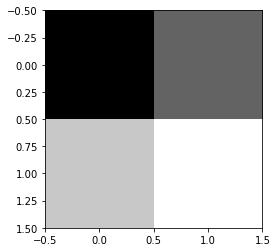

In [16]:
#Testing 

test_img = np.array([[1, 100], [200, 255]])
plt.imshow(test_img, cmap='gray')

In [17]:
test_qc = encode_image(test_img)
test_qc.draw()

░      ┌───┐      ░                           ░                     »
q_0: ──────░──────┤ X ├──────░───────────────────────────░─────────────────────»
           ░      └─┬─┘      ░                           ░                     »
q_1: ──────░────────┼────────░───────────────────────────░─────────────────────»
           ░        │        ░                ┌───┐      ░                     »
q_2: ──────░────────┼────────░────────────────┤ X ├──────░─────────────────────»
           ░        │        ░                └─┬─┘      ░                ┌───┐»
q_3: ──────░────────┼────────░──────────────────┼────────░────────────────┤ X ├»
           ░        │        ░                  │        ░                └─┬─┘»
q_4: ──────░────────┼────────░──────────────────┼────────░──────────────────┼──»
           ░        │        ░           ┌───┐  │        ░                  │  »
q_5: ──────░────────┼────────░───────────┤ X ├──┼────────░──────────────────┼──»
           ░        │        ░      ┌───┐└─┬─┘  │        ░           ┌───┐  │  »
q_6: ──────░────────┼────────░──────┤ X ├──┼────┼────────░───────────┤ X ├──┼──»
           ░        │        ░      └─┬─┘  │    │        ░      ┌───┐└─┬─┘  │  »
q_7: ──────░────────┼────────░────────┼────┼────┼────────░──────┤ X ├──┼────┼──»
     ┌───┐ ░ ┌───┐  │  ┌───┐ ░        │    │    │        ░ ┌───┐└─┬─┘  │    │  »
q_8: ┤ H ├─░─┤ X ├──■──┤ X ├─░────────■────■────■────────░─┤ X ├──■────■────■──»
     ├───┤ ░ ├───┤  │  ├───┤ ░ ┌───┐  │    │    │  ┌───┐ ░ └───┘  │    │    │  »
q_9: ┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ X ├──■────■────■──┤ X ├─░────────■────■────■──»
     └───┘ ░ └───┘     └───┘ ░ └───┘               └───┘ ░                     »
c: 4/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«           ░                                    ┌───┐ ░ 
«q_0: ──────░────────────────────────────────────┤ X ├─░─
«           ░                               ┌───┐└─┬─┘ ░ 
«q_1: ──────░───────────────────────────────┤ X ├──┼───░─
«           ░                          ┌───┐└─┬─┘  │   ░ 
«q_2: ──────░──────────────────────────┤ X ├──┼────┼───░─
«           ░                     ┌───┐└─┬─┘  │    │   ░ 
«q_3: ──────░─────────────────────┤ X ├──┼────┼────┼───░─
«           ░                ┌───┐└─┬─┘  │    │    │   ░ 
«q_4: ──────░────────────────┤ X ├──┼────┼────┼────┼───░─
«           ░           ┌───┐└─┬─┘  │    │    │    │   ░ 
«q_5: ──────░───────────┤ X ├──┼────┼────┼────┼────┼───░─
«           ░      ┌───┐└─┬─┘  │    │    │    │    │   ░ 
«q_6: ──────░──────┤ X ├──┼────┼────┼────┼────┼────┼───░─
«           ░ ┌───┐└─┬─┘  │    │    │    │    │    │   ░ 
«q_7: ──────░─┤ X ├──┼────┼────┼────┼────┼────┼────┼───░─
«     ┌───┐ ░ └─┬─┘  │    │    │    │    │    │    │   ░ 
«q_8: ┤ X ├─░───■────■────■────■────■────■────■────■───░─
«     └───┘ ░   │    │    │    │    │    │    │    │   ░ 
«q_9: ──────░───■────■────■────■────■────■────■────■───░─
«           ░                                          ░ 
«c: 4/═══════════════════════════════════════════════════
«

# Layer Creation

We next define two methods to create our rotation layers and entangling layers

In [18]:
# Methods for creating layers

def entangle_layer(circ, gamma):
    '''Creates (num_qubits choose 2) entanglements between the qubits
    gamma is vector of angles with length num_qubits '''
    
    for i in range(len(circ.qubits)):
        for j in range(i + 1, len(circ.qubits)):
            circ.rxx(gamma[i], i, j)
            
    circ.barrier()
    return circ

def rotation_layer(circ, beta):
    '''Creates rotation layer : R_z(a) R_x(b) R_z(c) on every qubit
    where a, b, c are different'''
    
#     print(beta, 'bveta')
    for i in range(len(circ.qubits)):
        circ.rz(beta[0], i)
        circ.rx(beta[1], i)
        circ.rz(beta[2], i)
        
    circ.barrier()
    return circ
    
#testing    
circuit = QuantumCircuit(10)
circuit = entangle_layer(circuit, [random.uniform(0.0,2.*math.pi) for eng in range(10)])
circuit = rotation_layer(circuit, [random.uniform(0.0, 2.*math.pi) for eng in range(3)])
circuit.draw()

┌──────────────┐┌──────────────┐┌──────────────┐                 »
q_0: ┤0             ├┤0             ├┤0             ├─────────────────»
     │  Rxx(5.1196) ││              ││              │┌───────────────┐»
q_1: ┤1             ├┤  Rxx(5.1196) ├┤              ├┤0              ├»
     └──────────────┘│              ││  Rxx(5.1196) ││  Rxx(0.58739) │»
q_2: ────────────────┤1             ├┤              ├┤1              ├»
                     └──────────────┘│              │└───────────────┘»
q_3: ────────────────────────────────┤1             ├─────────────────»
                                     └──────────────┘                 »
q_4: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_5: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_6: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_7: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_8: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_9: ─────────────────────────────────────────────────────────────────»
                                                                      »
«     ┌──────────────┐                 ┌──────────────┐                 »
«q_0: ┤0             ├─────────────────┤0             ├─────────────────»
«     │              │┌───────────────┐│              │┌───────────────┐»
«q_1: ┤              ├┤0              ├┤              ├┤0              ├»
«     │              ││               ││              ││               │»
«q_2: ┤  Rxx(5.1196) ├┤  Rxx(0.58739) ├┤              ├┤               ├»
«     │              ││               ││  Rxx(5.1196) ││  Rxx(0.58739) │»
«q_3: ┤              ├┤1              ├┤              ├┤               ├»
«     │              │└───────────────┘│              ││               │»
«q_4: ┤1             ├─────────────────┤              ├┤1              ├»
«     └──────────────┘                 │              │└───────────────┘»
«q_5: ─────────────────────────────────┤1             ├─────────────────»
«                                      └──────────────┘                 »
«q_6: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_7: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_8: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_9: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«                     ┌──────────────┐                                 »
«q_0: ────────────────┤0             ├─────────────────────────────────»
«                     │              │┌───────────────┐                »
«q_1: ────────────────┤              ├┤0              ├────────────────»
«     ┌──────────────┐│              ││               │┌──────────────┐»
«q_2: ┤0             ├┤              ├┤               ├┤0             ├»
«     │  Rxx(4.3184) ││              ││               ││              │»
«q_3: ┤1             ├┤  Rxx(5.1196) ├┤  Rxx(0.58739) ├┤  Rxx(4.3184) ├»
«     └──────────────┘│              ││               ││              │»
«q_4: ────────────────┤              ├┤               ├┤1             ├»
«                     │              ││               │└──────────────┘»
«q_5: ────────────────┤              ├┤1              ├────────────────»
«                     │              │└───────────────┘        

We are now ready to create the function that will implement our entire circuit ansatz

In [19]:
#creating circuit ansatz

def create_initial_params(num_layers, img_len):
    '''Creates a random set of initial gamma and beta parameters'''
    
    num_qubits = 8 + math.ceil(np.log2(img_len ** 2))
    gamma = [[random.uniform(0.0, 2.0 * math.pi) for j in range(num_qubits)] for i in range(num_layers)]
    beta = [[random.uniform(0.0, 2.0 * math.pi) for xx in range(3)] for alpha in range(num_layers)]
    return np.array(beta), np.array(gamma)

def create_ansatz(circuit, gammas, betas):
    '''Prepares the circuit ansatz
    gammas and betas are 2D arrays of size num_layers'''
    
#     print(gammas, 'gammas')
#     print(betas, 'betas')
    num_layers = len(gammas)
    for i in range(num_layers):
        circuit = entangle_layer(rotation_layer(circuit, betas[i]), gammas[i])
    circuit.measure(range(4), range(4))
    return circuit

#testing - 3 rotation and entanglement layers
sample_circ = create_ansatz(QuantumCircuit(5, 4), [[random.uniform(0.0, 2. * math.pi) for i in range(5)] for i in range(3)], [[random.uniform(0.0, 2. * math.pi) for i in range(3)] for j in range(3)])
sample_circ.draw()

┌────────────┐┌────────────┐┌────────────┐ ░ ┌──────────────┐»
q_0: ┤ Rz(5.6481) ├┤ Rx(1.2568) ├┤ Rz(3.0487) ├─░─┤0             ├»
     ├────────────┤├────────────┤├────────────┤ ░ │  Rxx(4.4056) │»
q_1: ┤ Rz(5.6481) ├┤ Rx(1.2568) ├┤ Rz(3.0487) ├─░─┤1             ├»
     ├────────────┤├────────────┤├────────────┤ ░ └──────────────┘»
q_2: ┤ Rz(5.6481) ├┤ Rx(1.2568) ├┤ Rz(3.0487) ├─░─────────────────»
     ├────────────┤├────────────┤├────────────┤ ░                 »
q_3: ┤ Rz(5.6481) ├┤ Rx(1.2568) ├┤ Rz(3.0487) ├─░─────────────────»
     ├────────────┤├────────────┤├────────────┤ ░                 »
q_4: ┤ Rz(5.6481) ├┤ Rx(1.2568) ├┤ Rz(3.0487) ├─░─────────────────»
     └────────────┘└────────────┘└────────────┘ ░                 »
c: 4/═════════════════════════════════════════════════════════════»
                                                                  »
«     ┌──────────────┐┌──────────────┐                 ┌──────────────┐»
«q_0: ┤0             ├┤0             ├─────────────────┤0             ├»
«     │              ││              │┌───────────────┐│              │»
«q_1: ┤  Rxx(4.4056) ├┤              ├┤0              ├┤              ├»
«     │              ││  Rxx(4.4056) ││  Rxx(0.87783) ││              │»
«q_2: ┤1             ├┤              ├┤1              ├┤  Rxx(4.4056) ├»
«     └──────────────┘│              │└───────────────┘│              │»
«q_3: ────────────────┤1             ├─────────────────┤              ├»
«                     └──────────────┘                 │              │»
«q_4: ─────────────────────────────────────────────────┤1             ├»
«                                                      └──────────────┘»
«c: 4/═════════════════════════════════════════════════════════════════»
«                                                                      »
«                                                                         »
«q_0: ────────────────────────────────────────────────────────────────────»
«     ┌───────────────┐┌───────────────┐                                  »
«q_1: ┤0              ├┤0              ├──────────────────────────────────»
«     │               ││               │┌───────────────┐┌───────────────┐»
«q_2: ┤  Rxx(0.87783) ├┤               ├┤0              ├┤0              ├»
«     │               ││  Rxx(0.87783) ││  Rxx(0.33257) ││               │»
«q_3: ┤1              ├┤               ├┤1              ├┤  Rxx(0.33257) ├»
«     └───────────────┘│               │└───────────────┘│               │»
«q_4: ─────────────────┤1              ├─────────────────┤1              ├»
«                      └───────────────┘                 └───────────────┘»
«c: 4/════════════════════════════════════════════════════════════════════»
«                                                                         »
«                     ░ ┌─────────────┐┌────────────┐┌────────────┐ ░ »
«q_0: ────────────────░─┤ Rz(0.12357) ├┤ Rx(2.4752) ├┤ Rz(5.4725) ├─░─»
«                     ░ ├─────────────┤├────────────┤├────────────┤ ░ »
«q_1: ────────────────░─┤ Rz(0.12357) ├┤ Rx(2.4752) ├┤ Rz(5.4725) ├─░─»
«                     ░ ├─────────────┤├────────────┤├────────────┤ ░ »
«q_2: ────────────────░─┤ Rz(0.12357) ├┤ Rx(2.4752) ├┤ Rz(5.4725) ├─░─»
«     ┌─────────────┐ ░ ├─────────────┤├────────────┤├────────────┤ ░ »
«q_3: ┤0            ├─░─┤ Rz(0.12357) ├┤ Rx(2.4752) ├┤ Rz(5.4725) ├─░─»
«     │  Rxx(2.742) │ ░ ├─────────────┤├────────────┤├────────────┤ ░ »
«q_4: ┤1            ├─░─┤ Rz(0.12357) ├┤ Rx(2.4752) ├┤ Rz(5.4725) ├─░─»
«     └─────────────┘ ░ └─────────────┘└────────────┘└────────────┘ ░ »
«c: 4/════════════════════════════════════════════════════════════════»
«                                                                     »
«     ┌───────────────┐┌───────────────┐┌───────────────┐                »
«q_0: ┤0              ├┤0              ├┤0              ├────────────────»
«     │  Rxx(0.72503) ││               ││               │┌──────────────┐»
«q_1: ┤1              ├

It is now time to create the actual Machine Learning framework!

In [20]:
def create_batches(x, y, batch_size):
    '''Takes training data and labels and returns batches of size batch_size. A batch is a list of the form [x, y]'''
    
    assert batch_size <= len(x), 'Batch size must be lower than number of training samples'
    assert len(x) == len(y), 'There must be as many training samples as there are targets'
    
    all_data = list(zip(x, y)) #batch size is 1 here
    num_regular_batches, num_extra_batches = len(all_data) // batch_size, len(all_data) % batch_size
    batches = [all_data[batch_size * i:batch_size * (i + 1)] for i in range(num_regular_batches)]
    if num_extra_batches != 0:
        extra_batches = list(all_data[-num_extra_batches:])
        batches.append(extra_batches)
    return batches

def convdictOneHot(dictionary):
    '''Takes in a dictionary of outcome:prob(outcome) pairs and outputs corresponding one-hot vector'''
    
    array, total = np.zeros(16), 0
    for key, val in dictionary.items():
        array[key] = val
        total += val
    return (array / total)[0:10]

def convLabelOneHot(label):
    '''Takes in label and returns corresponding one-hot vector'''
    
    result = np.zeros(10)
    result[label] = 1
    return result

def process_batch(beta, gamma, batch):
    '''Takes in a batch of instances and outputs predictions and targets'''
    
    x, y = [item[0] for item in batch], [convLabelOneHot(item[1]) for item in batch]
    circuits = [create_ansatz(encode_image(x_i), gamma, beta) for x_i in x]
    results = [execute(circuit, backend=Aer.get_backend('qasm_simulator')).result() for circuit in circuits]
    counts = [{key[::-1]:val for key, val in result.get_counts().items()} for result in results]
#     print('Pre-Counts:', counts)
    counts = [convdictOneHot({conv_binary_decimal(key):val for key, val in count.items()}) for count in counts]
#     print('Post-Counts:', counts)
    return counts, y

#testing
x_dat = [1, 2, 3, 4]
y_dat = [2, 1, 3, 4]
batch_size = 3
print(create_batches(x_dat, y_dat, batch_size))
print(convLabelOneHot(9))

[[(1, 2), (2, 1), (3, 3)], [(4, 4)]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [21]:
def train(x_train, y_train, batch_size, beta, gamma, num_epochs):
    '''Conducts entire ML training procedure'''
    
    num_layers = len(beta)
    n_qubits = 8 + math.ceil(np.log2(len(x_train[0]) ** 2))
    batches = create_batches(x_train, y_train, batch_size)
    parameters = []
    for i in beta:
        for j in i:
            parameters.append(j)
#     print('params check', parameters)
    for i in gamma:
        for j in i:
            parameters.append(j)

    epoch_costs = []
    print('Size of training dataset : ', len(x_train))
    print('Batch Size : ', batch_size)
    print('Number of Iterations per Epoch: ', len(batches))
    print('Number of Epochs : ', num_epochs, '\n')
    
    for n_epoch in range(num_epochs):
        print("\033[4mEpoch #{}\033[0m".format(n_epoch + 1))
        parameters, costs = epoch(batches, parameters, num_layers, n_qubits)
        epoch_costs.append(costs[-1])
        print('Cost at end of Epoch: ', costs[-1])

    return parameters, epoch_costs

def epoch(batches, parameters, num_layers, n_qubits):
    '''Conducts one epoch of training of ML model '''
    
    counter = 0
    costs = []
    for batch in batches:
        print('\nIteration #', counter + 1)
        parameters, curr_cost = optimise_once(parameters, batch, num_layers, n_qubits)
        costs.append(curr_cost)
        counter += 1
    
    return parameters, costs

def optimise_once(parameters, batch, num_layers, n_qubits):
    '''Runs the optimisation sequence for the one provided batch. Returns optimised beta and gamma'''
    
    def obj(x):
#         print('x = ', x)
        beta, gamma = [x[:num_layers * 3][i * 3:(i + 1) * 3] for i in range(num_layers)], [x[3 * num_layers:][n_qubits * i:n_qubits * (i + 1)] for i in range(num_layers)]
#         print('oiergoiergoi', beta)
#         print('iubwegiuerigub', gamma)
        batch_counts, batch_targets = process_batch(beta, gamma, batch)
#         print('Jingle Bell!!!!!', batch_counts, 'Madar***d', batch_targets)
        print('Jingle Bells!!!')
#         return np.average(categorical_crossentropy(batch_targets, batch_counts).numpy())
#         print(batch_counts, 'barier', batch_targets, 'otras')
        error_vectors = [batch_counts[i] - batch_targets[i] for i in range(len(batch_counts))]
#         print('error_vectors', error_vectors)
        return np.average([np.linalg.norm(e_vec) for e_vec in error_vectors])
    
    x0 = np.array(parameters)
    bounds = [(0, 2 * np.pi) for i in range(len(parameters))]
    constraints = []
    
    #COBYLA doesn't take bounds, so defining inequality constraints
    for i in range(len(bounds)):
        lower, upper = bounds[i]
        lower_constraint = {'type':'ineq', 'fun':lambda x, lower_bound=lower, j=i : x[j] - lower_bound}
        upper_constraint = {'type':'ineq', 'fun':lambda x, upper_bound=upper, j=i : upper_bound - x[j]}
        constraints.append(lower_constraint)
        constraints.append(upper_constraint)

    print('Cost before optimizing : ', obj(parameters))    
    sol = minimize(obj, x0, options={'disp':True}, method='COBYLA', constraints=constraints)
    print('Successful : ', sol['success'])
    curr_cost = obj(sol['x'])
    print('Current Cost : ', curr_cost)
    print('Message:', sol['message'])
    return sol['x'], curr_cost

In [28]:
def filter_ab(x, y, to_keep):
    keep = (y == to_keep)
    x, y = x[keep], y[keep]
    return x,y

X_train_small: (60000, 16, 16)


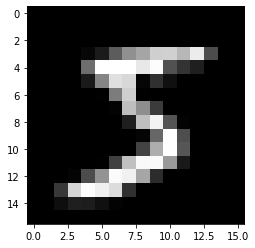

In [30]:
p = 3
batch_size = 10
num_epochs = 10
(train_x, train_y), (test_x, test_y) = mnist.load_data()
# to_keep = np.array([0,1,2,3,4])
# (train_x, train_y) = filter_ab(train_x, train_y,to_keep)
# (test_x, test_y) = filter_ab(test_x, test_y,to_keep)

x_train_expand = np.expand_dims(train_x, axis=-1)
x_train_small = tf.image.resize(x_train_expand,(16,16)).numpy().astype(int)[:,:,:,0]
print('X_train_small: ' + str(x_train_small.shape))
init_beta, init_gamma = create_initial_params(p, len(train_x[0]))
train_x, train_y = x_train_small[0:50], train_y[0:50]
plt.imshow(train_x[0], cmap='gray')

In [12]:
# p = 3
# batch_size = 5
# num_epochs = 10
# (train_x, train_y), (test_x, test_y) = mnist.load_data()
# to_keep = np.array([0,1,2,3,4])
# train_x = np.expand_dims(train_x, axis=-1)
# train_x = tf.image.resize(train_x,[16,16]).numpy().astype(int)
# init_beta, init_gamma = create_initial_params(p, len(train_x[0]))
# train_x, train_y = np.array([train_x[i] for i in range(200) if train_y[i] in to_keep]), [train_y[i] for i in range(200) if train_y[i] in to_keep]
# print('Length of Training Set = ', len(train_x))
# plt.imshow(train_x[0], cmap='gray')

In [13]:
# optimised_params, costs = train(train_x, train_y, batch_size, init_beta, init_gamma, num_epochs)

# # should visualize the cost function going down
# plt.plot(np.array([i for i in range(num_epochs)]), costs)

In [13]:
encode_image(train_x[0]).draw()

░       ░                ┌───┐ ░                     ┌───┐      ░ »
 q_0: ──────░───────░────────────────┤ X ├─░─────────────────────┤ X ├──────░─»
            ░       ░                └─┬─┘ ░                     └─┬─┘      ░ »
 q_1: ──────░───────░──────────────────┼───░───────────────────────┼────────░─»
            ░       ░           ┌───┐  │   ░                ┌───┐  │        ░ »
 q_2: ──────░───────░───────────┤ X ├──┼───░────────────────┤ X ├──┼────────░─»
            ░       ░           └─┬─┘  │   ░                └─┬─┘  │        ░ »
 q_3: ──────░───────░─────────────┼────┼───░──────────────────┼────┼────────░─»
            ░ ┌───┐ ░      ┌───┐  │    │   ░           ┌───┐  │    │        ░ »
 q_4: ──────░─┤ X ├─░──────┤ X ├──┼────┼───░───────────┤ X ├──┼────┼────────░─»
            ░ └─┬─┘ ░      └─┬─┘  │    │   ░           └─┬─┘  │    │        ░ »
 q_5: ──────░───┼───░────────┼────┼────┼───░─────────────┼────┼────┼────────░─»
            ░   │   ░        │    │    │   ░             │    │    │        ░ »
 q_6: ──────░───┼───░────────┼────┼────┼───░─────────────┼────┼────┼────────░─»
            ░   │   ░ ┌───┐  │    │    │   ░      ┌───┐  │    │    │        ░ »
 q_7: ──────░───┼───░─┤ X ├──┼────┼────┼───░──────┤ X ├──┼────┼────┼────────░─»
      ┌───┐ ░   │   ░ └─┬─┘  │    │    │   ░      └─┬─┘  │    │    │        ░ »
 q_8: ┤ H ├─░───■───░───■────■────■────■───░────────■────■────■────■────────░─»
      ├───┤ ░   │   ░   │    │    │    │   ░        │    │    │    │        ░ »
 q_9: ┤ H ├─░───■───░───■────■────■────■───░────────■────■────■────■────────░─»
      ├───┤ ░   │   ░   │    │    │    │   ░        │    │    │    │        ░ »
q_10: ┤ H ├─░───■───░───■────■────■────■───░────────■────■────■────■────────░─»
      ├───┤ ░   │   ░   │    │    │    │   ░        │    │    │    │        ░ »
q_11: ┤ H ├─░───■───░───■────■────■────■───░────────■────■────■────■────────░─»
      ├───┤ ░   │   ░   │    │    │    │   ░        │    │    │    │        ░ »
q_12: ┤ H ├─░───■───░───■────■────■────■───░────────■────■────■────■────────░─»
      ├───┤ ░   │   ░   │    │    │    │   ░ ┌───┐  │    │    │    │  ┌───┐ ░ »
q_13: ┤ H ├─░───■───░───■────■────■────■───░─┤ X ├──■────■────■────■──┤ X ├─░─»
      ├───┤ ░   │   ░   │    │    │    │   ░ └───┘  │    │    │    │  └───┘ ░ »
q_14: ┤ H ├─░───■───░───■────■────■────■───░────────■────■────■────■────────░─»
      ├───┤ ░   │   ░   │    │    │    │   ░        │    │    │    │        ░ »
q_15: ┤ H ├─░───■───░───■────■────■────■───░────────■────■────■────■────────░─»
      └───┘ ░       ░                      ░                                ░ »
 c: 4/════════════════════════════════════════════════════════════════════════»
                                                                              »
«            ░           ┌───┐ ░            ░                                ░ »
« q_0: ──────░───────────┤ X ├─░────────────░────────────────────────────────░─»
«            ░           └─┬─┘ ░            ░                          ┌───┐ ░ »
« q_1: ──────░─────────────┼───░────────────░──────────────────────────┤ X ├─░─»
«            ░      ┌───┐  │   ░            ░                          └─┬─┘ ░ »
« q_2: ──────░──────┤ X ├──┼───░────────────░────────────────────────────┼───░─»
«            ░      └─┬─┘  │   ░            ░                     ┌───┐  │   ░ »
« q_3: ──────░────────┼────┼───░────────────░─────────────────────┤ X ├──┼───░─»
«      ┌───┐ ░ ┌───┐  │    │   ░            ░                ┌───┐└─┬─┘  │   ░ »
« q_4: ┤ X ├─░─┤ X ├──┼────┼───░────────────░────────────────┤ X ├──┼────┼───░─»
«      └─┬─┘ ░ └─┬─┘  │    │   ░            ░           ┌───┐└─┬─┘  │    │   ░ »
« q_5: ──┼───░───┼────┼────┼───░────────────░───────────┤ X ├──┼────┼────┼───░─»
«        │   ░   │    │    │   ░      ┌───┐ ░      ┌───┐└─┬─┘  │    │    │   ░ »
« q_6: ──┼───░───┼────┼────┼───░──────┤ X ├─░──────┤ X ├──┼────┼────┼────┼───░─»
«        │   ░   │    │    │   ░ ┌───┐└─┬─┘ ░ ┌───┐└─┬─┘  │    │    │    │   ░